
### FINAL CODE

In [2]:
# Import Statements

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import joblib
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import cv2
import torch
from pathlib import Path
from scipy.signal import savgol_filter
import folium
from imblearn.over_sampling import SMOTE
from moviepy.editor import VideoFileClip
from PIL import Image
import torch
import os




In [2]:
# Load the data

data2 = pd.read_csv(r"D:\Semester 2\Thesis Project\Data\Galway Data\data2.csv")
data3 = pd.read_csv(r"D:\Semester 2\Thesis Project\Data\Galway Data\data3.csv")
data_india_sampled = pd.read_csv(r"D:\Semester 2\Thesis Project\Data\Galway Data\data_india_sampled.csv")
galway_data_merged = pd.read_csv(r"D:\Semester 2\Thesis Project\Data\Galway Data\galway_data_merged.csv")
new_training_set = pd.read_csv(r"D:\Semester 2\Thesis Project\Data\Galway Data\training_data_complete.csv")
testing_1 = pd.read_csv(r"D:\Semester 2\Thesis Project\Data\Galway Data\testing_1.csv")
testing_2 = pd.read_csv(r"D:\Semester 2\Thesis Project\Data\Galway Data\testing_2.csv")

In [3]:
def preprocess_and_smooth_data(data):

    col_to_select = ['seconds_elapsed', 'accelerometer_z', 'accelerometer_x', 'accelerometer_y', 'location_latitude', 'location_longitude']
    data = data[col_to_select]
    data = data.dropna().reset_index(drop=True)

    # Apply a low-pass filter (moving average) to accelerometer
    smoothed_columns = ['accelerometer_z', 'accelerometer_x', 'accelerometer_y']

    for col in smoothed_columns:
        # Use Savitzky-Golay filter for smoothing
        data[col + '_smooth'] = savgol_filter(data[col], window_length=5, polyorder=3)

    return data

In [4]:
# Label the data based on the accelerometer data

def labelling_data(data):
    accelerometer_y_avg = data['accelerometer_y_smooth'].mean()
    accelerometer_x_avg = data['accelerometer_x_smooth'].mean()
    accelerometer_z_avg = data['accelerometer_z_smooth'].mean()
    data.loc[:, 'accelerometer_y_data'] = data['accelerometer_y_smooth'] - accelerometer_y_avg
    data.loc[:, 'accelerometer_x_data'] = data['accelerometer_x_smooth'] - accelerometer_x_avg
    data.loc[:, 'accelerometer_z_data'] = data['accelerometer_z_smooth'] - accelerometer_z_avg
    data.loc[:, 'label'] = np.where((data['accelerometer_y_data'].diff() > 0.2) | (data['accelerometer_x_data'].diff() > 0.2) | (data['accelerometer_z_data'].diff() > 0.3), 0, 1)
    #data = data.drop("accelerometer_avg", axis=1)

    return data

In [5]:
# Extract features and labels
def training_preprocess(data):
    relevant_columns = ['accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'accelerometer_y_smooth', 'accelerometer_x_smooth', 'accelerometer_z_smooth']
    X = data[relevant_columns]
    y = data["label"]
    return X, y

In [6]:
# Process New Data for Prediction

def process_new_data(data):
    new_data = preprocess_and_smooth_data(data)
    relevant_columns = ['accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'accelerometer_y_smooth', 'accelerometer_x_smooth', 'accelerometer_z_smooth']
    new_data = new_data[relevant_columns]

    return new_data


In [7]:
# Process Sample Data for further use

def process_sample_data(data):
    sample_data = preprocess_and_smooth_data(data)
    relevant_columns = ['seconds_elapsed', 'accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'accelerometer_y_smooth', 'accelerometer_x_smooth', 'accelerometer_z_smooth', 'location_longitude', 'location_latitude']
    sample_data = sample_data[relevant_columns]

    return sample_data

In [8]:
data = preprocess_and_smooth_data(new_training_set)

In [9]:
data.head()

,seconds_elapsed,accelerometer_z,accelerometer_x,accelerometer_y,location_latitude,location_longitude,accelerometer_z_smooth,accelerometer_x_smooth,accelerometer_y_smooth
0,201,-0.009704,-0.015115,0.041667,53.282589,-9.060869,-0.015518,-0.020098,0.041589
1,202,0.005780,-0.150541,-0.060869,53.282583,-9.060932,0.029033,-0.130608,-0.060556
2,203,0.072912,-0.039663,-0.024636,53.282579,-9.060982,0.038033,-0.069562,-0.025106
3,204,0.010719,-0.031703,0.018395,53.282574,-9.061051,0.046969,-0.060834,-0.013373
4,205,0.045157,-0.127058,-0.058269,53.282569,-9.061131,0.007887,-0.059459,-0.026792


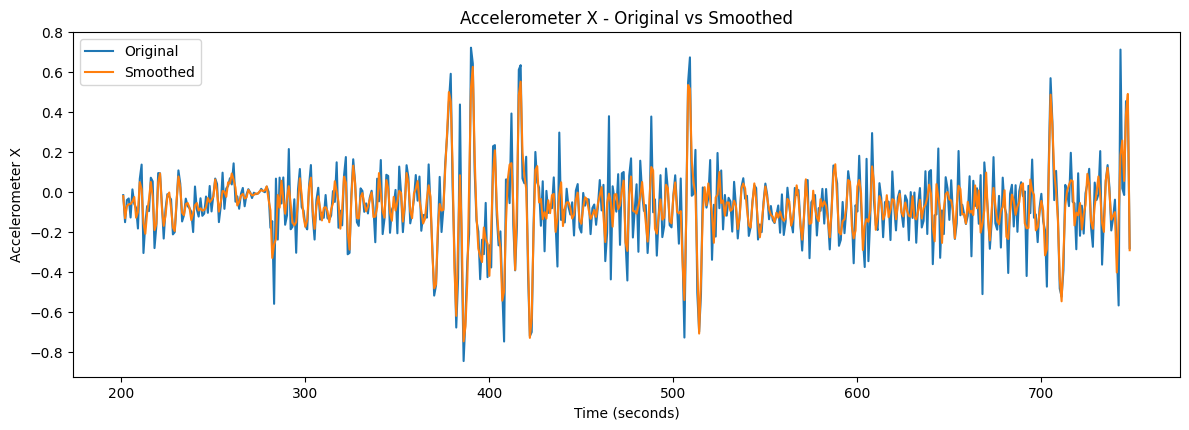

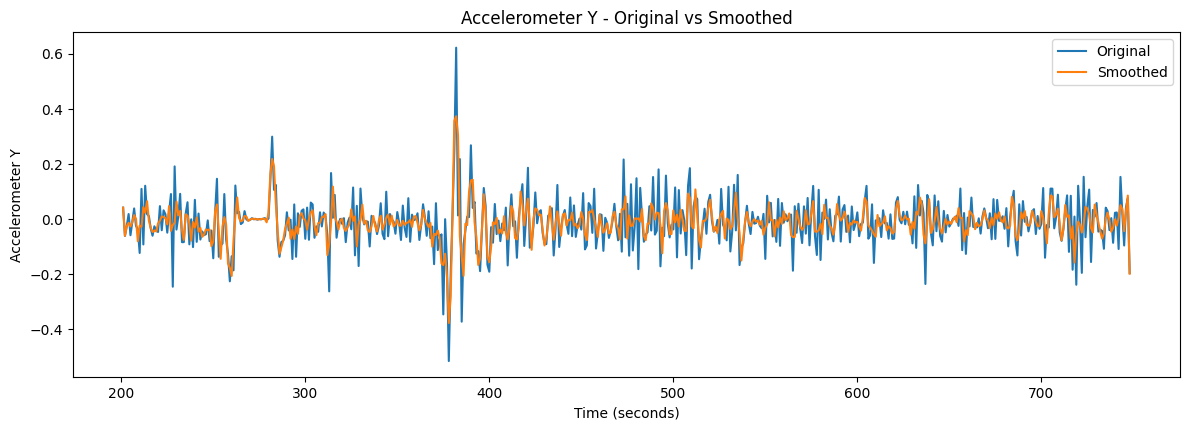

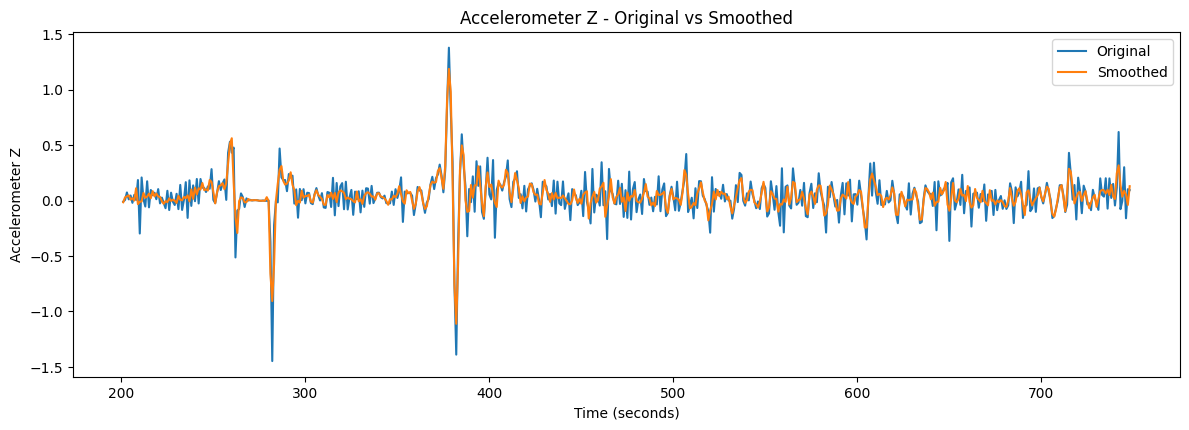

In [10]:
# Plot the values of the original and smoothed accelerometer data

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(data['seconds_elapsed'], data['accelerometer_x'], label='Original')
plt.plot(data['seconds_elapsed'], data['accelerometer_x_smooth'], label='Smoothed')
plt.xlabel('Time (seconds)')
plt.ylabel('Accelerometer X')
plt.title('Accelerometer X - Original vs Smoothed')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(data['seconds_elapsed'], data['accelerometer_y'], label='Original')
plt.plot(data['seconds_elapsed'], data['accelerometer_y_smooth'], label='Smoothed')
plt.xlabel('Time (seconds)')
plt.ylabel('Accelerometer Y')
plt.title('Accelerometer Y - Original vs Smoothed')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(data['seconds_elapsed'], data['accelerometer_z'], label='Original')
plt.plot(data['seconds_elapsed'], data['accelerometer_z_smooth'], label='Smoothed')
plt.xlabel('Time (seconds)')
plt.ylabel('Accelerometer Z')
plt.title('Accelerometer Z - Original vs Smoothed')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
labelled_data = labelling_data(data)
labelled_data.value_counts('label')

label
1    505
0     43
Name: count, dtype: int64

In [12]:
X, y = training_preprocess(data)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [13]:

X, y = training_preprocess(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Support Vector Machine": SVC(kernel="rbf", random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000)
}

kf = KFold(n_splits=10, shuffle=True, random_state=17)
results = {}

for name, model in models.items():
    cv_results = cross_val_score(model, X_train_balanced, y_train_balanced, cv=kf, scoring='accuracy')
    model.fit(X, y)
    y_pred = cross_val_predict(model, X_train_balanced, y_train_balanced, cv=kf)
    report = classification_report(y_train_balanced, y_pred, output_dict=True)
    results[name] = {
        "accuracy": np.mean(cv_results),
        "classification_report": report
    }

# Split the data into training and test sets for Neural Network
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a simple neural network
def create_nn_model(input_shape):
    model = Sequential()
    model.add(Dense(128, input_shape=(input_shape,), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(2, activation='softmax'))  # 2 classes: Optimal Ride, Non-Optimal Ride
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

nn_model = create_nn_model(X_train.shape[1])
nn_model.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate neural network model
nn_accuracy = nn_model.evaluate(X_test, y_test, verbose=0)[1]
nn_y_pred = nn_model.predict(X_test)
nn_y_pred_classes = np.argmax(nn_y_pred, axis=1)
nn_report = classification_report(y_test, nn_y_pred_classes, output_dict=True)

# Add neural network results to results dictionary
results["Neural Network"] = {
    "accuracy": nn_accuracy,
    "classification_report": nn_report
}

# Generate a summary report
summary = []
for name, result in results.items():
    summary.append(f"Model: {name}")
    summary.append(f"Accuracy: {result['accuracy']:.4f}")
    summary.append("Classification Report:")
    summary.append(pd.DataFrame(result["classification_report"]).transpose().to_string())
    summary.append("\n")

print("\n".join(summary))

c:\Users\Sharaj\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8794 - loss: 0.6457 - val_accuracy: 0.9091 - val_loss: 0.5529
Epoch 2/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9095 - loss: 0.5168 - val_accuracy: 0.9091 - val_loss: 0.4267
Epoch 3/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9165 - loss: 0.3851 - val_accuracy: 0.9091 - val_loss: 0.3371
Epoch 4/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9184 - loss: 0.3207 - val_accuracy: 0.9091 - val_loss: 0.3088
Epoch 5/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9108 - loss: 0.3234 - val_accuracy: 0.9091 - val_loss: 0.2957
Epoch 6/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9244 - loss: 0.2852 - val_accuracy: 0.9091 - val_loss: 0.2848
Epoch 7/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9349 - loss: 0.2453 - val_accuracy: 0.9091 - val_loss: 0.2772
Epoch 8/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9341 - loss: 0.2476 - val_accuracy: 0.9091 - val_loss

In [15]:
# Processing sample data for use

sample_data = process_sample_data(testing_1)
sample_data.head()

,seconds_elapsed,accelerometer_x,accelerometer_y,accelerometer_z,accelerometer_y_smooth,accelerometer_x_smooth,accelerometer_z_smooth,location_longitude,location_latitude
0,0,0.294579,-0.045744,0.109687,-0.037085,0.240281,0.072814,-9.048435,53.281915
1,1,0.014368,0.163884,-0.225415,0.129246,0.231562,-0.077925,-9.048445,53.281941
2,2,0.318711,0.012770,0.066371,0.064726,-0.007080,-0.154864,-9.048505,53.281965
3,3,-0.456088,-0.000683,-0.285991,-0.007042,-0.150111,-0.092676,-9.048547,53.281991
4,4,-0.172832,0.015771,0.027537,0.021861,-0.353875,-0.091108,-9.048580,53.282020


In [16]:

# Save each model
joblib.dump(models["Random Forest"], "random_forest_model.pkl")
joblib.dump(models["Support Vector Machine"], "svm_model.pkl")
joblib.dump(models["K-Nearest Neighbors"], "knn_model.pkl")
joblib.dump(models["Logistic Regression"], "logistic_regression_model.pkl")
nn_model.save("neural_network_model.h5")

# Load the models
rf_model = joblib.load("random_forest_model.pkl")
svm_model = joblib.load("svm_model.pkl")
knn_model = joblib.load("knn_model.pkl")
logreg_model = joblib.load("logistic_regression_model.pkl")
nn_model = tf.keras.models.load_model("neural_network_model.h5")

new_data = process_new_data(sample_data)
new_data_scaled = scaler.transform(new_data)

# Get predictions
rf_predictions = rf_model.predict(new_data_scaled)
svm_predictions = svm_model.predict(new_data_scaled)
knn_predictions = knn_model.predict(new_data_scaled)
logreg_predictions = logreg_model.predict(new_data_scaled)
nn_predictions = np.argmax(nn_model.predict(new_data_scaled), axis=1)


# Print predictions
def print_predictions(predictions, model_name):
    unique, counts = np.unique(predictions, return_counts=True)
    pred_counts = dict(zip(unique, counts))
    total_predictions = len(predictions)
    good_quality_percentage = pred_counts.get(1, 0) / total_predictions * 100
    bad_quality_percentage = pred_counts.get(0, 0) / total_predictions * 100
    print(f"{model_name} Predictions: {predictions}")
    print(f"{model_name} Prediction Counts: {pred_counts}")
    print(f"{model_name} Road Quality - Good: {good_quality_percentage:.2f}% | Bad: {bad_quality_percentage:.2f}%")
    print('----------------------------------------')

print_predictions(rf_predictions, "Random Forest")
print_predictions(svm_predictions, "Support Vector Machine")
print_predictions(knn_predictions, "K-Nearest Neighbors")
print_predictions(logreg_predictions, "Logistic Regression")
print_predictions(nn_predictions, "Neural Network")


c:\Users\Sharaj\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Sharaj\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\Sharaj\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\Sharaj\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Random Forest Predictions: [0 1 0 1 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 1
 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 0 1 0 1 0 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 0]
Random Forest Prediction Counts: {0: 32, 1: 69}
Random Forest Road Quality - Good: 68.32% | Bad: 31.68%
----------------------------------------
Support Vector Machine Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1]
Support Vector Machine Prediction Counts: {0: 1, 1: 100}
Support Vector Machine Road Quality - Good: 99.01% | Bad: 0.99%
----------------------------------------
K-Nearest Neighbors Predictions: [1 1 1 0 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1

In [17]:
# Append the generated labels to the sample_data

sample_data['label'] = nn_predictions
sample_data.head()

,seconds_elapsed,accelerometer_x,accelerometer_y,accelerometer_z,accelerometer_y_smooth,accelerometer_x_smooth,accelerometer_z_smooth,location_longitude,location_latitude,label
0,0,0.294579,-0.045744,0.109687,-0.037085,0.240281,0.072814,-9.048435,53.281915,0
1,1,0.014368,0.163884,-0.225415,0.129246,0.231562,-0.077925,-9.048445,53.281941,0
2,2,0.318711,0.012770,0.066371,0.064726,-0.007080,-0.154864,-9.048505,53.281965,0
3,3,-0.456088,-0.000683,-0.285991,-0.007042,-0.150111,-0.092676,-9.048547,53.281991,0
4,4,-0.172832,0.015771,0.027537,0.021861,-0.353875,-0.091108,-9.048580,53.282020,1


In [18]:
def create_map_with_path_and_markers(sample_data):
    
    map_display = folium.Map(location=[sample_data['location_latitude'].mean(), sample_data['location_longitude'].mean()], zoom_start=15)

    # Collect coordinates for the path
    path_coords = []
    for idx, row in sample_data.iterrows():
        path_coords.append([row['location_latitude'], row['location_longitude']])
        if row['label'] == 0:
            folium.CircleMarker(
                location=[row['location_latitude'], row['location_longitude']],
                radius=5,
                color='red',
                fill=True,
                fill_color='red',
                popup=f"Ride quality was not optimal here"
            ).add_to(map_display)

    # Add the path
    folium.PolyLine(path_coords, color="blue", weight=2.5, opacity=1).add_to(map_display)
    map_display.save('path_map.html')
    return map_display

map_display = create_map_with_path_and_markers(sample_data)
map_display

In [19]:


# Load YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

def crop_frame(frame, x1, y1, x2, y2):
    return frame[y1:y2, x1:x2]

def apply_yolo_on_video(input_path, x1, y1, x2, y2, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    with VideoFileClip(input_path) as video:
        duration = int(video.duration)
        
        for t in range(0, duration):
            frame = video.get_frame(t)
            cropped_frame = crop_frame(frame, x1, y1, x2, y2)
            img = Image.fromarray(cropped_frame)
            results = model(img)
            results.show()
            
            # Save the image with elapsed seconds as the filename
            img.save(os.path.join(output_folder, f"{t}_seconds_elapsed.png"))

def create_map_with_path_and_markers(sample_data, images_folder):
    map_display = folium.Map(location=[sample_data['location_latitude'].mean(), sample_data['location_longitude'].mean()], zoom_start=15)

    path_coords = []
    for idx, row in sample_data.iterrows():
        path_coords.append([row['location_latitude'], row['location_longitude']])
        
        # Only add markers where label is 0
        if row['label'] == 0:
            # Image path based on seconds elapsed
            image_url = f"http://127.0.0.1:5000/images/{int(row['seconds_elapsed'])}.png"
            
            # Create popup with image
            iframe = folium.IFrame(f'<img src="{image_url}" width="800" height="800">')  
            popup = folium.Popup(iframe, max_width=820)
            
            folium.CircleMarker(
                location=[row['location_latitude'], row['location_longitude']],
                radius=5,
                color='red',
                fill=True,
                fill_color='red',
                popup=popup
            ).add_to(map_display)

    # Add the path as a PolyLine
    folium.PolyLine(path_coords, color="blue", weight=2.5, opacity=1).add_to(map_display)

    # Save the map to an HTML file
    map_display.save('path_map.html')

    # Display the map (for Jupyter Notebooks)
    return map_display

# Example usage:
input_video_path = r"D:\Semester 2\Thesis Project\Data\Galway Data\2024-07-28\Camera\1722183981223.mp4"
top_left_x = 150
top_left_y = 200
bottom_right_x = 650
bottom_right_y = 800
output_folder = r"D:\Semester 2\Thesis Project\Data\Galway Data\2024-07-28\Camera\CroppedFrames"

# Apply YOLO on the video and save the cropped frames
#apply_yolo_on_video(input_video_path, top_left_x, top_left_y, bottom_right_x, bottom_right_y, output_folder)

# Generate the map
map_display = create_map_with_path_and_markers(sample_data, output_folder)

# Display the map
map_display


Using cache found in C:\Users\Sharaj/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-5-14 Python-3.12.0 torch-2.3.0+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [20]:

# Load YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

def crop_frame(frame, x1, y1, x2, y2):
    """
    Crop a single frame.
    
    Args:
    - frame: np.array, frame to crop.
    - x1, y1: int, coordinates of the top-left corner.
    - x2, y2: int, coordinates of the bottom-right corner.
    
    Returns:
    - Cropped frame.
    """
    return frame[y1:y2, x1:x2]

def apply_yolo_on_video(input_path, x1, y1, x2, y2, output_folder):
    """
    Apply YOLOv5 object detection on cropped frames of the video.
    
    Args:
    - input_path: str, path to the input video file.
    - x1, y1: int, coordinates of the top-left corner for cropping.
    - x2, y2: int, coordinates of the bottom-right corner for cropping.
    - output_folder: str, path to the folder to save cropped images.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    with VideoFileClip(input_path) as video:
        duration = int(video.duration)
        
        for t in range(0, duration):
            frame = video.get_frame(t)
            cropped_frame = crop_frame(frame, x1, y1, x2, y2)
            # Convert cropped frame to PIL image
            img = Image.fromarray(cropped_frame)
            # Perform YOLOv5 detection
            results = model(img)
            # Display results
            results.show()
            
            # Save the image with elapsed seconds as the filename
            img.save(os.path.join(output_folder, f"{t}.png"))

def create_map_with_path_and_markers(sample_data, images_folder):
    """
    Create a folium map with path and markers.

    Args:
    - sample_data: DataFrame containing the sample data with lat, long, and labels.
    - images_folder: str, path to the folder containing the images.
    """
    # Create a map centered around the average latitude and longitude
    map_display = folium.Map(location=[sample_data['location_latitude'].mean(), sample_data['location_longitude'].mean()], zoom_start=15)

    # Collect coordinates for the path
    path_coords = []
    for idx, row in sample_data.iterrows():
        path_coords.append([row['location_latitude'], row['location_longitude']])
        
        # Only add markers where label is 0
        if row['label'] == 0:
            image_url = f"http://127.0.0.1:5000/images/{int(row['seconds_elapsed'])}.png"
            
            html = f"""
            <html>
                <body>
                    <a href="{image_url}" target="_blank">Click here to view full-size image</a>
                </body>
            </html>
            """
            iframe = folium.IFrame(html)
            popup = folium.Popup(iframe, max_width=300)
            
            folium.CircleMarker(
                location=[row['location_latitude'], row['location_longitude']],
                radius=5,
                color='red',
                fill=True,
                fill_color='red',
                popup=popup
            ).add_to(map_display)

    # Add the path as a PolyLine
    folium.PolyLine(path_coords, color="blue", weight=2.5, opacity=1).add_to(map_display)
    map_display.save('path_map.html')
    return map_display

# Example usage:
input_video_path = r"D:\Semester 2\Thesis Project\Data\Galway Data\2024-07-28\Camera\1722183981223.mp4"
top_left_x = 150
top_left_y = 200
bottom_right_x = 650
bottom_right_y = 800
output_folder = r"D:\Semester 2\Thesis Project\Data\Galway Data\2024-07-28\Camera\CroppedFrames"

# Apply YOLO on the video and save the cropped frames
#apply_yolo_on_video(input_video_path, top_left_x, top_left_y, bottom_right_x, bottom_right_y, output_folder)

# Generate the map
map_display = create_map_with_path_and_markers(sample_data, output_folder)

# Display the map
map_display


Using cache found in C:\Users\Sharaj/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-5-14 Python-3.12.0 torch-2.3.0+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [21]:
map_display.save('path_map_1.html')

In [23]:

# Initialize a list to store the evaluation metrics
evaluation_matrix = []

def extract_metrics(report):
    return (report['0']['precision'], report['0']['recall'], report['0']['f1-score'],
            report['1']['precision'], report['1']['recall'], report['1']['f1-score'])

for name, result in results.items():
    # Extract accuracy and metrics for each class
    accuracy = result["accuracy"]
    precision_c0, recall_c0, f1_c0, precision_c1, recall_c1, f1_c1 = extract_metrics(result["classification_report"])
    
    # Append the metrics to the evaluation matrix
    evaluation_matrix.append([name, accuracy, precision_c0, recall_c0, f1_c0, precision_c1, recall_c1, f1_c1])

# Create a DataFrame for better visualization
columns = ["Model", "Accuracy", "Precision (Class 0)", "Recall (Class 0)", "F1-Score (Class 0)",
           "Precision (Class 1)", "Recall (Class 1)", "F1-Score (Class 1)"]
evaluation_df = pd.DataFrame(evaluation_matrix, columns=columns)

# Print the evaluation matrix
print(evaluation_df)


                    Model  Accuracy  Precision (Class 0)  Recall (Class 0)  \
0           Random Forest  0.915448             0.901442          0.932836   
1  Support Vector Machine  0.776188             0.796791          0.741294   
2     K-Nearest Neighbors  0.866759             0.801636          0.975124   
3     Logistic Regression  0.702654             0.709512          0.686567   
4          Neural Network  0.936364             0.500000          0.142857   

   F1-Score (Class 0)  Precision (Class 1)  Recall (Class 1)  \
0            0.916870             0.930412          0.898010   
1            0.768041             0.758140          0.810945   
2            0.879910             0.968254          0.758706   
3            0.697851             0.696386          0.718905   
4            0.222222             0.944444          0.990291   

   F1-Score (Class 1)  
0            0.913924  
1            0.783654  
2            0.850767  
3            0.707466  
4            0.966825  


In [24]:
evaluation_df

,Model,Accuracy,Precision (Class 0),Recall (Class 0),F1-Score (Class 0),Precision (Class 1),Recall (Class 1),F1-Score (Class 1)
0,Random Forest,0.915448,0.901442,0.932836,0.916870,0.930412,0.898010,0.913924
1,Support Vector Machine,0.776188,0.796791,0.741294,0.768041,0.758140,0.810945,0.783654
2,K-Nearest Neighbors,0.866759,0.801636,0.975124,0.879910,0.968254,0.758706,0.850767
3,Logistic Regression,0.702654,0.709512,0.686567,0.697851,0.696386,0.718905,0.707466
4,Neural Network,0.936364,0.500000,0.142857,0.222222,0.944444,0.990291,0.966825
